# Example 3.1
The Graphical and numerical solution to the $\beta$ eigenvalue equation.

We have a planar dielectric structure shown below. We want to determine the allowed values of $\beta$, assuming the wavelength of the light exciting the waveguide is 1 $\mu\text{m}$.

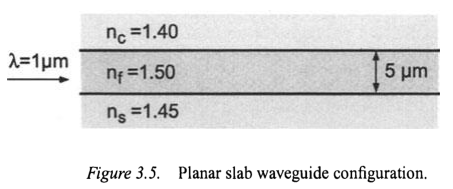

### Solution

In this case, we need to solve the eigenvalue equation
$$\tan(h\kappa_f) = \frac{\gamma_c + \gamma_s}{\kappa_f\bigg[1 - \frac{\gamma_c\gamma_s}{\kappa_f^2}\bigg]}$$

Here, we know that $\beta$ is the z-component of the $k_0n_f$, hence $0< \beta < k_0n_f$. Also, when it says $\lambda$ is used to excite the waveguide, it is used to calculate the $k_0$. We took a different approach from the book, the book parameterized the value of $\kappa_f$ instead of $\beta$. It somehow seems easier to solve (?)

In [151]:
# Import libraries and define variables
import numpy as np
import photonics_tools.basic_tools as tools
import photonics_tools.slab_1d_tools as slab
import matplotlib.pyplot as plt
from scipy.optimize import minimize, fsolve
from scipy.integrate import quad

# Define variables
lamb0 = 1e-6 # meter
nc = 1.4
nf = 1.5
ns = 1.45
d = 5e-6 # meter of core thickness

k0 = tools.lamb2wavevector(lamb_vac=lamb0)
omega0 = tools.lamb2omega(lamb=lamb0)

In [152]:
# Now we can start solving things
beta = np.linspace(k0*ns, k0*nf, 1000) # beta ranges between 0 and k0*nf. But when it is less than k0*ns, it's not confining anymore, but let's try anyway
gammac = slab.attenuation_coefficient(k0, nc, beta)
gammas = slab.attenuation_coefficient(k0, ns, beta)
kappaf = slab.transverse_wavevector(k0, nf, beta)

In [153]:
y1 = np.tan(d*kappaf)
y2 = (gammac + gammas)/(kappaf*(1-((gammac*gammas)/(kappaf**2))))

C:\Users\cahya\AppData\Local\Temp\ipykernel_5312\1940723714.py:2: RuntimeWarning: divide by zero encountered in divide
  y2 = (gammac + gammas)/(kappaf*(1-((gammac*gammas)/(kappaf**2))))
C:\Users\cahya\AppData\Local\Temp\ipykernel_5312\1940723714.py:2: RuntimeWarning: invalid value encountered in multiply
  y2 = (gammac + gammas)/(kappaf*(1-((gammac*gammas)/(kappaf**2))))


In [154]:
# We need to find the solution via rootfinding

def functional(beta):
    kapf = slab.transverse_wavevector(k0, nf, beta)
    gamc = slab.attenuation_coefficient(k0, nc, beta)
    gams = slab.attenuation_coefficient(k0, ns, beta)
    return np.abs((np.tan(d*kapf)) - ((gamc + gams)/(kapf*(1-((gamc*gams)/(kapf**2))))))

#sol = minimize(functional, 9.424777e6, bounds=[(9.35e6, k0*nf-1e-6)])
sol = fsolve(functional, [9.175e6, 9.25e6, 9.35e6, 9.4e6]) # The initial guess is acquired from the graph
print(sol) # This result is the same as the one we got in the book.

[9175214.99416081 9281844.87217623 9360796.84377473 9408732.72761188]


[]

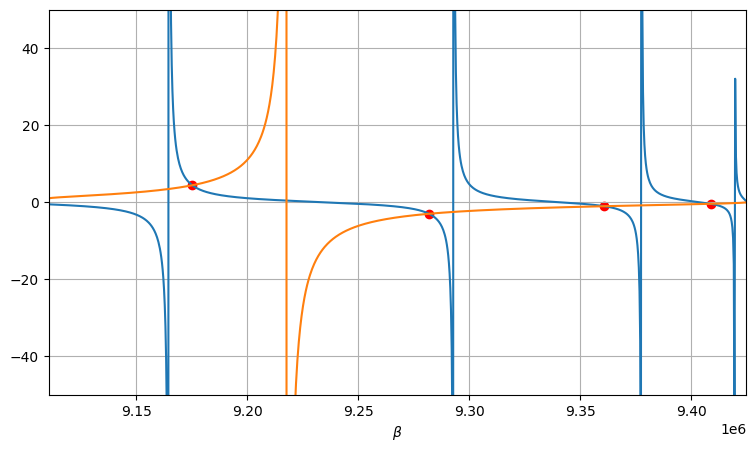

In [155]:
fig, ax = plt.subplots(1,1,figsize = (9,5))
ax.plot(beta, y1)
ax.plot(beta, y2)
for s in sol:
    ax.scatter(s, np.tan(d*slab.transverse_wavevector(k0, nf, s)), color = 'red')
ax.set_ylim([-50,50])
ax.set_xlim([k0*ns, k0*nf])
ax.grid(True)
ax.set_xlabel("$\\beta$")
plt.plot()

### Extra:
We now want to see how the $\beta$'s correspond to the modes contained in the waveguide, we already solved the equation and acquired that:
$$E_y(x) = \begin{cases}
Ae^{-\gamma_c x} & x>0\\
A\bigg[\cos(\kappa_f x) - \frac{\gamma_c}{\kappa_f} \sin(\kappa_f x)\bigg] & -h<x<0\\
A\bigg[\cos(\kappa_f h) + \frac{\gamma_c}{\kappa_f} \sin(\kappa_f h)\bigg] e^{\gamma_s(x+h)} & x<-h
\end{cases}$$

In [163]:
# Now we define the above equation into a function
def E_y(x, A, h, gammac, kappaf, gammas):
    
    if x>0:
        return A*np.exp(-gammac*x)
    elif x>-h:
        return A*(np.cos(kappaf*x) - (gammac/kappaf)*np.sin(kappaf*x))
    else:
        return A*(np.cos(kappaf*h) + (gammac/kappaf)*np.sin(kappaf*h))*np.exp(gammas*(x+h))

In [164]:
# Define another function for the square of E_y
def E_y_square(x, A, h, gammac, kappaf, gammas):
    return E_y(x, A, h, gammac, kappaf, gammas)**2

Now we want to do integration to get the power. The resulting value is:
$$P_z = \frac{\beta}{2\omega \mu_0} \int_{-\infty}^{\infty} \left|E_y\right|^2 dx$$

In [167]:
# Let's set A to 1, and then we can normalize it later:
A = 1
norm_factor = np.zeros_like(sol)

# We iterate over the beta solutions
for i, bet in enumerate(sol):
    power = (bet/(2*omega0*tools.VACUUM_PERMEABILITY)) * quad(E_y_square, a = -1e-3, b = 1e-3, args = (A, d, slab.attenuation_coefficient(k0, nc, bet), slab.transverse_wavevector(k0, nf, bet), slab.attenuation_coefficient(k0, ns, bet)))[0]
    norm_factor[i] = np.sqrt(1/power)
    

1.4694308929861094e-08
2.4439083130408608e-08
5.4100084673137356e-08
2.15241223802284e-07


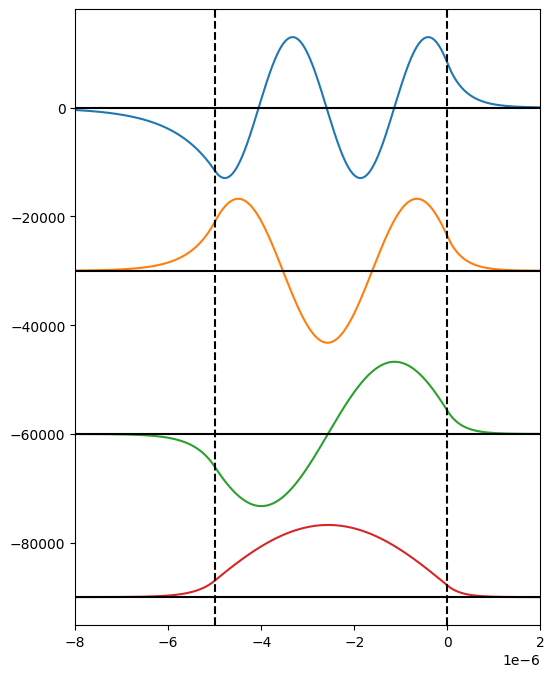

In [176]:
# Now, we want to plot our function in the range of interest

xmax = 2e-6
xmin = -8e-6
x_array = np.linspace(xmin, xmax, 1000)
y_array = np.zeros_like(x_array)

fig_mode, ax_mode = plt.subplots(1,1, figsize = (6,8))
for i, bet in enumerate(sol):
    for j, x in enumerate(x_array):
        y_array[j] = E_y(x, norm_factor[i], d, slab.attenuation_coefficient(k0, nc, bet), slab.transverse_wavevector(k0, nf, bet), slab.attenuation_coefficient(k0, ns, bet)) - i*3e4
    ax_mode.plot(x_array, y_array)
    ax_mode.axhline(-i*3e4, color = 'black')
    
ax_mode.set_xlim((xmin, xmax))
ax_mode.axvline(0, color = 'black', linestyle = '--')
ax_mode.axvline(-5e-6, color = 'black', linestyle = '--')